### Dependencies

In [1]:
'''
Visualization tools are adapted from https://github.com/facebookresearch/dino.
'''

# Base Dependencies
import argparse
import colorsys
import os
import random
import sys
import requests
from io import BytesIO

# LinAlg / Stats / Plotting Dependencies
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import skimage.io
from skimage.measure import find_contours
from tqdm import tqdm

# Torch Dependencies
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

# Utils
import nn_encoder_arch.vision_transformer as vits
from attention_visualization_utils import create_256x256_map_concat

### Loading Pretrained ViT-S/16

In [2]:
arch = 'vit_small'
patch_size = 16
pretrained_weights = './ckpts/vits_tcga_brca_dino.pt'
checkpoint_key = 'teacher'
threshold = 0.5

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Build model
model = vits.__dict__[arch](patch_size=patch_size, num_classes=0)
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)

if os.path.isfile(pretrained_weights):
    state_dict = torch.load(pretrained_weights, map_location="cpu")
    if checkpoint_key is not None and checkpoint_key in state_dict:
        print(f"Take key {checkpoint_key} in provided checkpoint dict")
        state_dict = state_dict[checkpoint_key]
    # remove `module.` prefix
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    msg = model.load_state_dict(state_dict, strict=False)
    print('Pretrained weights found at {} and loaded with msg: {}'.format(pretrained_weights, msg))

Take key teacher in provided checkpoint dict
Pretrained weights found at ./ckpts/vits_tcga_brca_dino.pt and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


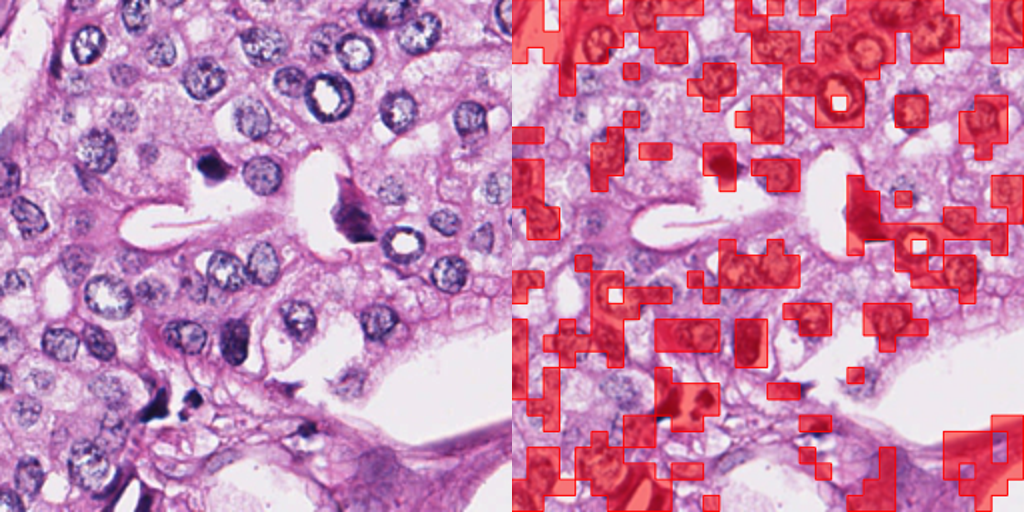

In [4]:
img_fname = 'image_256.png'
img = Image.open('./image_demo/%s' % img_fname)
output_dir = './attention_visualization_results/image_256/'
os.makedirs(output_dir, exist_ok=True)

create_256x256_map_concat(model, img, img_fname, output_dir, display=True)

In [5]:
img_fname = 'image_4k.png'
img = np.array(Image.open('./image_demo/%s' % img_fname))
save_fname = img_fname
output_dir = './attention_visualization_results/image_4k/'
os.makedirs(output_dir, exist_ok=True)

for i in tqdm(range(0, 4096, 256)):
    for j in range(0, 4096, 256):
        patch = Image.fromarray(img[i:(i+256),j:(j+256),:])
        subimg_fname = 'image_%d_%d.png' % (i,j)
        create_256x256_map_concat(model, patch, subimg_fname, output_dir, image_size=(256,256), display=False)

100%|██████████| 16/16 [00:00<00:00, 54032.90it/s]
